# Deskripsi Proyek ML
Sistem rekomendasi buku ini akan dibangun menggunakan algoritma machine learning content based filtering yang dapat belajar dari dataset buku yang diperoleh dari kaggle. Dengan menganalisis deskripsi judul buku dan rating dari data set, sistem akan menghasilkan rekomendasi yang lebih personal dan akurat. Tujuan utama proyek ini adalah meningkatkan pengalaman membaca pengguna dengan menyajikan buku-buku yang sesuai dengan minat mereka.

# Tahap 1 Instalansi dan Persiapan Library
  Pada tahap, dilakukan persiapan semua pustaka Python yang diperlukan seperti pandas yang digunakan untuk untuk manipulasi data maupun matplotlib untuk visualisasi data



  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tabulate import tabulate
import seaborn as sns
from sklearn.metrics import f1_score

#Tahap 2: Data Loading

Pada tahap ini akan dilakukan pemuatan dataset dari kaggle (https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data). Dataset yang dimuat ke dalam Google Colabs berasal dari sumber eksternal seperti file CSV. Proses ini memastikan data tersedia dalam format yang dapat diproses. Jumlah dan struktur data dilihat dengan menggunakan fungsi dengan head(). Dataset ini mengandung kolom seperti book_id, title ataupun author.

In [ ]:

# Tahap 2: Data download and Loading
# Unduh dataset
!pip install kaggle  # Pastikan Kaggle CLI terpasang

#Mount ke Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Pindahkan token API Kaggle ke direktori kerja Colab
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

 #Download Public Kaggle Dataset
!kaggle datasets download -d arashnic/book-recommendation-dataset -p ./data/

# Ekstrak dataset
import zipfile
with zipfile.ZipFile('./data/book-recommendation-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/')



Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
 70% 17.0M/24.3M [00:00<00:00, 68.6MB/s]
100% 24.3M/24.3M [00:00<00:00, 90.6MB/s]


In [ ]:
books = pd.read_csv("/content/data/Books.csv")
books.head()



<ipython-input-3-06043375c425>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("/content/data/Books.csv")


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
ratings = pd.read_csv("/content/data/Ratings.csv")
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
print('Jumlah buku dalam data:', len(books.ISBN.unique()))
print('Jumlah rating buku dalam data :', len(ratings.ISBN.unique()))

Jumlah buku dalam data: 271360
Jumlah rating buku dalam data : 340556


# Tahap 3 : Eksploration Data Analysis (EDA)

Sebelum melanjutkan ke model, kita perlu memahami distribusi data dan memeriksa karakteristik data. Selain itu pada tahap ini akan dilakukan analaisis jikalau ada data yang kurang baik untuk diproses dalam model.


# Tahap 3.1. EDA : Dataset Buku

Pada tahap ini akan dilakukan analisis dan perbaikan pada dataset buku

In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Tampak pada kolom Years-Of-Publication data type nya object padahal seharusnya integer, sehingga perlu dibenahi

In [ ]:
temp = (books['Year-Of-Publication'] == 'DK Publishing Inc') | (books['Year-Of-Publication'] == 'Gallimard')
books = books.drop(books[temp].index)
books[(books['Year-Of-Publication'] == 'DK Publishing Inc') | (books['Year-Of-Publication'] == 'Gallimard')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


In [ ]:
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)
print(books.dtypes)

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object


Sekarang, kita akan menampilkan 20 buku teratas berdasarkan jumlah buku yang dihasilkan penulis

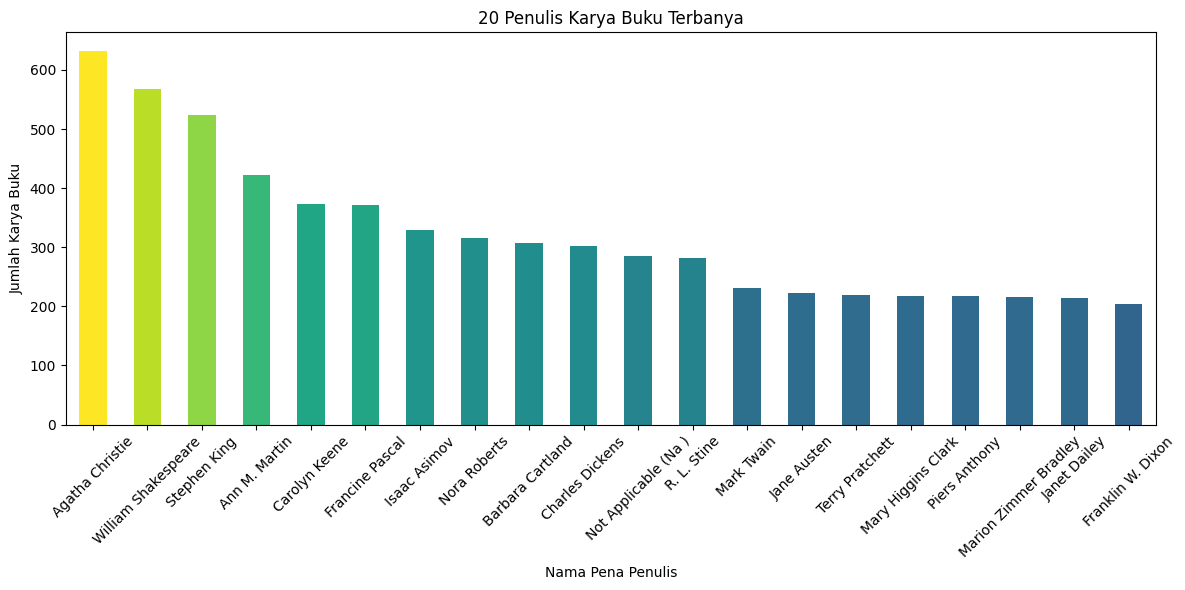

In [ ]:
# Penggabungan 'Book-Author'
# menghitung karya buku si penulis
author_counts = books.groupby('Book-Author')['Book-Title'].count()

# Urutkan penulis dari yang banyak hingga yang sedikti
sorted_authors = author_counts.sort_values(ascending=False)

# 20 penulis teratas
top_20_authors = sorted_authors.head(20)

# Plot 20 penulis teratas dengan plot batang dan warna
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(top_20_authors.values / float(max(top_20_authors.values)))
top_20_authors.plot(kind='bar', color=colors)
plt.xlabel('Nama Pena Penulis')
plt.ylabel('Jumlah Karya Buku')
plt.title('20 Penulis Karya Buku Terbanya')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Wow...Agatha Christie menjadi penulis dengan karya terbanyak sebesar 600 lebih buku

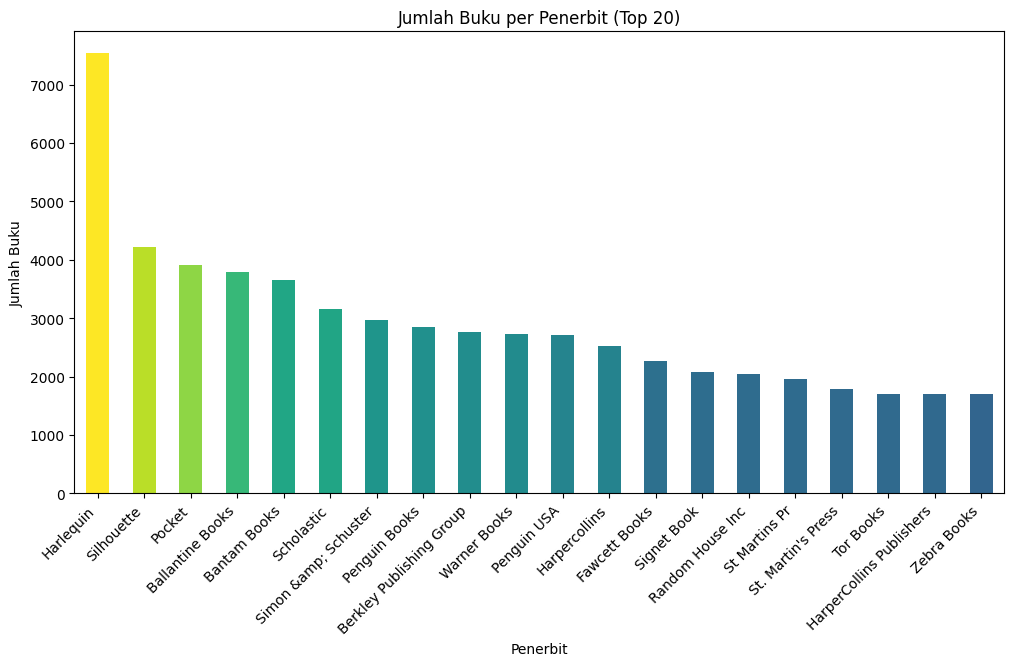

In [ ]:
# Visualisasi jumlah buku berdasarkan penerbit
plt.figure(figsize=(12, 6))
books['Publisher'].value_counts().head(20).plot(kind='bar', color=colors)
plt.title('Jumlah Buku per Penerbit (Top 20)')
plt.xlabel('Penerbit')
plt.ylabel('Jumlah Buku')
plt.xticks(rotation=45, ha='right')
plt.show()



# 3.2. EDA : Dataset Ratings

Pada tahapan selanjutnya dilakukan eksplorasi pada dataset ratings. Dataset rating ini juga nantinya akan digunakan untuk sistem rekomendasi buku dengan model collaborative filtering

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Kemudian, akan dilihat jumlah data dari masing-masing kolom

In [ ]:
print('Banyaknya User-ID:', len(ratings['User-ID'].unique()))
print('Banyaknya Karya Buku yang ber-ISBN:', len(ratings['ISBN'].unique()))

print('Jumlah 10 teratas dari rating buku:')
sorted_ratings = ratings['Book-Rating'].value_counts().sort_index()
pd.DataFrame({'Book-Rating': sorted_ratings.index, 'Jumlah': sorted_ratings.values})

Banyaknya User-ID: 105283
Banyaknya Karya Buku yang ber-ISBN: 340556
Jumlah 10 teratas dari rating buku:


,Book-Rating,Jumlah
0,0,716109
1,1,1770
2,2,2759
3,3,5996
4,4,8904
5,5,50974
6,6,36924
7,7,76457
8,8,103736
9,9,67541


Pada pengembangan model ini hanya akan digunakan 20000 data saja untuk menghemat waktu dalam menjalankan model

In [ ]:
df_rating = ratings[:20000]
df_rating

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
19995,3757,843222264X,7
19996,3757,8432222658,7
19997,3757,8432222666,7
19998,3757,8432222674,7


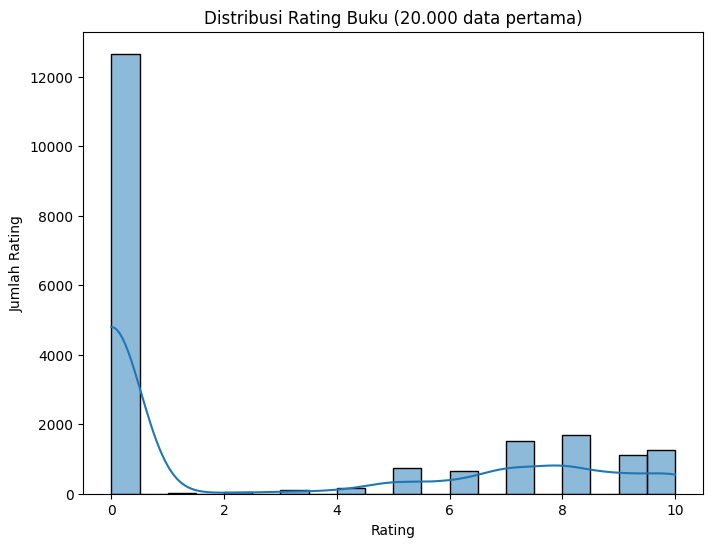

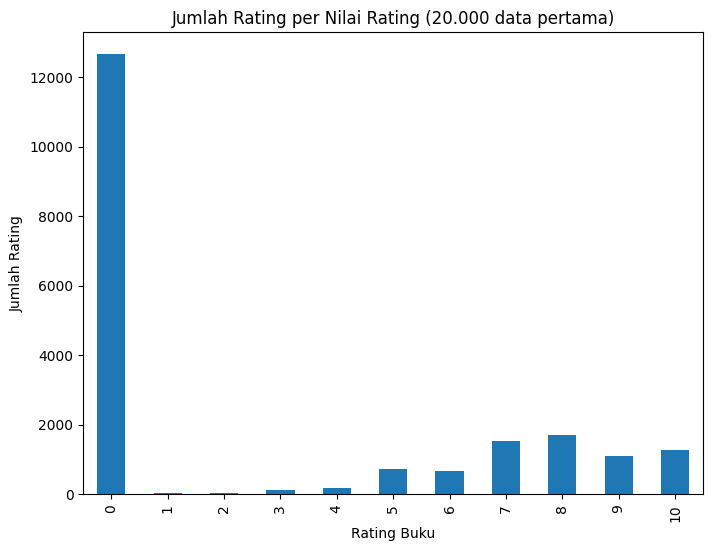

In [ ]:
# Visualisasi distribusi rating buku (menggunakan data yang sudah di-subset)
plt.figure(figsize=(8, 6))
sns.histplot(df_rating['Book-Rating'], kde=True)
plt.title('Distribusi Rating Buku (20.000 data pertama)')
plt.xlabel('Rating')
plt.ylabel('Jumlah Rating')
plt.show()

# Visualisasi jumlah rating per rating buku (menggunakan data yang sudah di-subset)
plt.figure(figsize=(8, 6))
df_rating['Book-Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Jumlah Rating per Nilai Rating (20.000 data pertama)')
plt.xlabel('Rating Buku')
plt.ylabel('Jumlah Rating')
plt.show()

# Tahap 4 : Data Preprocessing
 Pada tahap ini, 2 file terpisah yaitu books dan ratings, akan digabungankan menjadi 1 file. Hal ini dilakukan agar sesuai dengan pengembangan model.

In [ ]:
# Menggabungkan dataframe ratings dengan books berdasarkan nilai ISBN
books = pd.merge(ratings, books, on='ISBN', how='left')
books

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996.0,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
...,...,...,...,...,...,...,...,...,...,...
1149775,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000.0,Longstreet Press,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...
1149776,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997.0,Alfred A. Knopf,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...
1149777,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996.0,Jove Books,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...
1149778,276721,0590442449,10,Fourth Grade Rats,Jerry Spinelli,1996.0,Scholastic,http://images.amazon.com/images/P/0590442449.0...,http://images.amazon.com/images/P/0590442449.0...,http://images.amazon.com/images/P/0590442449.0...


In [ ]:
books.groupby('ISBN').sum()

,User-ID,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
ISBN,,,,,,,,,
0330299891,271009,6,0,0,0.0,0,0,0,0
0375404120,356057,3,0,0,0.0,0,0,0,0
0586045007,89192,0,0,0,0.0,0,0,0,0
9022906116,100868,7,0,0,0.0,0,0,0,0
9032803328,89192,0,0,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
cn113107,107301,0,0,0,0.0,0,0,0,0
ooo7156103,266146,7,0,0,0.0,0,0,0,0
§423350229,85250,0,0,0,0.0,0,0,0,0


# Tahap 5 : Data Preparation
Di tahap, akan dilakukan persiapan data seperti memeprbaiki missing value dan menyamakan jenis buku berdasarkan ISBN.
Pada sistem rekomendasi berbasis konten (content-based filtering) yang akan dikembangkan, satu nomor ISBN mewakili satu judul buku.

In [ ]:
# Cek missing value dengan fungsi isnull()
books.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0
Book-Title,118648
Book-Author,118650
Year-Of-Publication,118648
Publisher,118650
Image-URL-S,118648
Image-URL-M,118648
Image-URL-L,118648


Terdapat mising value dari Book-Title sampai Image-URL-L sehingga perlu untuk diperbaiki

In [ ]:
all_books_clean = books.dropna()
all_books_clean

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996.0,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
...,...,...,...,...,...,...,...,...,...,...
1149774,276704,0876044011,0,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998.0,A.R.E. Press (Association of Research &amp; Enlig,http://images.amazon.com/images/P/0876044011.0...,http://images.amazon.com/images/P/0876044011.0...,http://images.amazon.com/images/P/0876044011.0...
1149775,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000.0,Longstreet Press,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...
1149776,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997.0,Alfred A. Knopf,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...
1149777,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996.0,Jove Books,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...


Diperiksa kembali apakah ada misisng value

In [ ]:
all_books_clean.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0
Book-Title,0
Book-Author,0
Year-Of-Publication,0
Publisher,0
Image-URL-S,0
Image-URL-M,0
Image-URL-L,0


In [ ]:
# Mengurutkan buku berdasarkan ISBN kemudian memasukkannya ke dalam variabel fix_books
fix_books = all_books_clean.sort_values('ISBN', ascending=True)
fix_books

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
703628,171118,0000913154,8,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967.0,Simon &amp; Schuster,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...
357256,86123,0001010565,0,Mog's Christmas,Judith Kerr,1992.0,Collins,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...
866078,209516,0001010565,0,Mog's Christmas,Judith Kerr,1992.0,Collins,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...
103677,23902,0001046438,9,Liar,Stephen Fry,0.0,Harpercollins Uk,http://images.amazon.com/images/P/0001046438.0...,http://images.amazon.com/images/P/0001046438.0...,http://images.amazon.com/images/P/0001046438.0...
807953,196149,0001046713,0,Twopence to Cross the Mersey,Helen Forrester,1992.0,HarperCollins Publishers,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...
...,...,...,...,...,...,...,...,...,...,...
1100731,264317,B000234N76,0,Falling Angels,Tracy Chevalier,2001.0,E P Dutton,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...
423108,100906,B000234NC6,0,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002.0,Knopf,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...
419279,100088,B00029DGGO,0,"Good Wife Strikes Back, The",Elizabeth Buchan,0.0,Viking Adult,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...
743545,179791,B0002JV9PY,0,The Blockade Runners,Jules Verne,0.0,Digireads.com,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...


Dihitung jumlah nomor isbn yang ada dalam dataset

In [ ]:
# Mengecek berapa jumlah fix_books
len(fix_books['ISBN'].unique())

270144

Diperiksa kembali jumlah buku

In [ ]:
len(fix_books['Book-Title'].unique())

241065

Jumlah buku dan banyaknya ISBN tidak sama sehingga perlu diatasi dengan mengubah datasetnya menjadi data unik. Selain itu, diperlukan proses penghilangan data duplikat pada kolom 'ISBN' dan simpan ke dalam variabel baru.

In [ ]:
preparation = fix_books.drop_duplicates('ISBN')
preparation

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
703628,171118,0000913154,8,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967.0,Simon &amp; Schuster,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...
357256,86123,0001010565,0,Mog's Christmas,Judith Kerr,1992.0,Collins,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...
103677,23902,0001046438,9,Liar,Stephen Fry,0.0,Harpercollins Uk,http://images.amazon.com/images/P/0001046438.0...,http://images.amazon.com/images/P/0001046438.0...,http://images.amazon.com/images/P/0001046438.0...
807953,196149,0001046713,0,Twopence to Cross the Mersey,Helen Forrester,1992.0,HarperCollins Publishers,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...
103678,23902,000104687X,6,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993.0,HarperCollins Publishers,http://images.amazon.com/images/P/000104687X.0...,http://images.amazon.com/images/P/000104687X.0...,http://images.amazon.com/images/P/000104687X.0...
...,...,...,...,...,...,...,...,...,...,...
1100731,264317,B000234N76,0,Falling Angels,Tracy Chevalier,2001.0,E P Dutton,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...
423108,100906,B000234NC6,0,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002.0,Knopf,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...
419279,100088,B00029DGGO,0,"Good Wife Strikes Back, The",Elizabeth Buchan,0.0,Viking Adult,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...
743545,179791,B0002JV9PY,0,The Blockade Runners,Jules Verne,0.0,Digireads.com,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...


Kemudian dilakukan proses konversi data series menjadi list dengan fungsi tolist() dari library.

In [ ]:
# konversi data series 'ISBN' menjadi bentuk list
isbn_id = preparation['ISBN'].tolist()

# konversi data series 'Book-Title' menjadi bentuk list
book_title = preparation['Book-Title'].tolist()

# konversi data series 'Book-Author' menjadi bentuk list
book_author = preparation['Book-Author'].tolist()

# konversi data series 'Year-Of-Publication' menjadi bentuk list
year_of_publication = preparation['Year-Of-Publication'].tolist()

# konversi data series 'Publisher' menjadi bentuk list
publisher = preparation['Publisher'].tolist()

print(len(isbn_id))
print(len(book_title))
print(len(book_author))
print(len(year_of_publication))
print(len(publisher))

270144
270144
270144
270144
270144


Tahap berikutnya yaitu pembuatan dictionary untuk menentukan pasangan key-value pada data isbn_id, book_title, book_author, year_of_publication, dan publihser

In [ ]:
# Membuat dictionary untuk data ‘isbn_id’, ‘book_title’, ‘book_author’, 'year_of_publication', dan 'publisher'
books_new = pd.DataFrame({
    'isbn': isbn_id,
    'book_title': book_title,
    'book_author': book_author,
    'year_of_publication': year_of_publication,
    'publisher': publisher

})

books_new

,isbn,book_title,book_author,year_of_publication,publisher
0,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967.0,Simon &amp; Schuster
1,0001010565,Mog's Christmas,Judith Kerr,1992.0,Collins
2,0001046438,Liar,Stephen Fry,0.0,Harpercollins Uk
3,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992.0,HarperCollins Publishers
4,000104687X,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993.0,HarperCollins Publishers
...,...,...,...,...,...
270139,B000234N76,Falling Angels,Tracy Chevalier,2001.0,E P Dutton
270140,B000234NC6,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002.0,Knopf
270141,B00029DGGO,"Good Wife Strikes Back, The",Elizabeth Buchan,0.0,Viking Adult
270142,B0002JV9PY,The Blockade Runners,Jules Verne,0.0,Digireads.com


Untuk mengefisienkan waktu dalam permodelan, maka data yang akan digunakan hanya sampai pada urutan 20.000

In [ ]:
books_new = books_new[:20000]

In [ ]:
books_new

,isbn,book_title,book_author,year_of_publication,publisher
0,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967.0,Simon &amp; Schuster
1,0001010565,Mog's Christmas,Judith Kerr,1992.0,Collins
2,0001046438,Liar,Stephen Fry,0.0,Harpercollins Uk
3,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992.0,HarperCollins Publishers
4,000104687X,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993.0,HarperCollins Publishers
...,...,...,...,...,...
19995,0140444696,The Kreutzer Sonata and Other Stories (Penguin...,Leo Tolstoy,1986.0,Penguin Books
19996,014044470X,The Fiancee and Other Stories (Penguin Classics),Anton Pavlovich Chekhov,1986.0,Penguin Books
19997,0140444726,Jacques the Fatalist and His Master (Penguin C...,Denis Diderot,1986.0,Penguin Books
19998,0140444742,Seven Viking Romances (Penguin Classics),Hermann Palsson,1986.0,Penguin Books


# Tahap 6 Pembuatan Model: Content-Based Filtering

Pada tahap ini dilakukan pencarian representasi fitur penting dari setiap judul buku dengan TF-IDF (Term Frequency - Inverse Document Frequency) Vectorizer. Tahap ini juga akan Filtering menggunakan Cosine Similarity untuk menghitung derajat kesamaan antar buku.

In [ ]:
data = books_new
data.sample(5)

,isbn,book_title,book_author,year_of_publication,publisher
3843,0060161620,The Irreversible Decline of Eddie Socket: A Novel,John Weir,1989.0,Harpercollins
12531,0070316392,Brainwashing and Other Forms of Mind Control,"Margaret Oldroyd, Hyde",1977.0,McGraw Hill Children's Pub
9417,0061056219,The Lions of Al-Rassan,Guy Gavriel Kay,1996.0,Eos
10122,0061091960,Copperhead (Starbuck Chronicles),Bernard Cornwell,1995.0,HarperTorch
16606,0140143505,84 Charing Cross Road,Helene Hanff,1990.0,Penguin Books


# Tahap 6.1: TF-IDF Vectorizer
TF-IDF vectorizer adalah alat yang digunakan untuk mengonversi dokumen teks menjadi representasi vektor berdasarkan nilai TF-ID setiap kata dalam dokumen tersebut.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data book_author
tf.fit(data['book_author'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['1988', 'aaron', 'aarons', ..., 'zweifel', 'zwinger', 'â¼nter'],
      dtype=object)

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(data['book_author'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(20000, 8746)

In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# matriks tf-idf untuk beberapa judul buku dan nama penulis buku dalam bentuk dataframe
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=data.book_title
).sample(15, axis=1).sample(10, axis=0)

,hayden,quincey,rowlands,ainslie,stallworthy,warwick,freedberg,plath,virgil,marian,eberhardt,jay,moorhouse,gribbin,hawken
book_title,,,,,,,,,,,,,,,
365 Great Chocolate Desserts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Carpenter's Gothic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
White Rat: A Life in Baseball,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Art of Dreaming,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Missing World: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I'll Take You There : A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tips and Traps When Buying A Home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Puffin Book of Nursery Rhymes (Puffin Books),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Trigger,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Tahap 6.2 : Cosine Similarity
Pada tahap ini dilakukan proses menghitung derajat kesamaan (similarity degree) antar judul buku dengan teknik cosine similarity.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama judul buku
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['book_title'], columns=data['book_title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap judul buku
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (20000, 20000)


book_title,The hard life: A novel,"The Way We Lived Then: The \English Story\"" in the 1940s""",The Essential Kabbalah: The Heart of Jewish Mysticism,Date Like a Man: What Men Know About Dating and are Afraid You'll Find Out,Death and the Maiden (Penguin Plays)
book_title,,,,,
Innovation and Entrepreneurship: Practice and Principles,0.0,0.0,0.0,0.0,0.0
The Essay: Old and New,0.0,0.0,0.0,0.0,0.0
The Final Forest: The Battle for the Last Great Trees of the Pacific Northwest,0.0,0.0,0.0,0.0,0.0
"Amber Was Brave, Essie Was Smart",0.0,0.0,0.0,0.0,0.0
Introduction to Director and Lingo: Multimedia and Internet Applications,0.0,0.0,0.0,0.0,0.0
"Excavating Jesus : Beneath the Stones, Behind the Texts: Revised and Updated",0.0,0.0,0.0,0.0,0.0
Tortilla Flat,0.0,0.0,0.0,0.0,0.0
"Frommer's New York City With Kids, 6th Edition",0.0,0.0,0.0,0.0,0.0
The Making of The X-Files Film,0.0,0.0,0.0,0.0,0.0


# tahap 7 : Hasil Sistem Rekomendasi Buku

Pada tahap ini, dibuatlah sebuah sistem rekomendasi buku dengan beberapa parameter book_title, similarity_data,
items dan k yang merupakan top-N recommendation yang diberikan oleh sistem rekomendasi. Secara default, k itu sendiri bernilai 5.

In [ ]:
def book_recommendation(book_title, similarity_data=cosine_sim_df, items=data[['book_title', 'book_author']], k=5):
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,book_title].to_numpy().argpartition(range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop book_title agar nama buku yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(book_title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
book_title_test = "Entering the Silence : Becoming a Monk and a Writer (The Journals of Thomas Merton, V. 2)"
data[data.book_title.eq(book_title_test)]

,isbn,book_title,book_author,year_of_publication,publisher
6448,0060654775,Entering the Silence : Becoming a Monk and a W...,Thomas Merton,1997.0,HarperSanFrancisco


# Tahap 8 : Evaluasi Model
 Evaluasi dilakukan dengan menggunakan MSE dan RMSE sebagai  evaluasi untuk sistem rekomendasi. Nilai dari MSE dan RMSE memberikan gambaran yang lebih seimbang tentang performa model. MSE (Mean Squared Error) dan RMSE (Root Mean Squared Error) adalah metrik evaluasi yang umum digunakan untuk mengukur seberapa baik suatu model prediksi mendekati nilai sebenarnya.

In [ ]:
# Menentukan threshold untuk mengkategorikan similarity sebagai 1 atau 0
threshold = 0.5
# Membuat ground truth data dengan asumsi threshold
ground_truth = np.where(cosine_sim >= threshold, 1, 0)

# Menampilkan beberapa nilai pada ground truth matrix
ground_truth_df = pd.DataFrame(ground_truth, index=data['book_title'], columns=data['book_title']).sample(5, axis=1).sample(10, axis=0)

In [ ]:
ground_truth_df

book_title,Rome Access (Accessguides.),"The Four-Gated City (The Children of Violence, Book 5)",Concise Guide for Writers,Cat To The Dogs: A Joe Grey Mystery,Running In Heels: A Novel
book_title,,,,,
Raven in Amber (Harper Monogram),0,0,0,0,0
The Soul of the World: A Modern Book of Hours,0,0,0,0,0
Summer of the Spanish Woman,0,0,0,0,0
The Transformation and Other Stories: Works Published During Kafka's Lifetime (Twentieth-Century Classics),0,0,0,0,0
On the Road (Modern Classics S.),0,0,0,0,0
Hating Alison Ashley (Puffin Books),0,0,0,0,0
Dead Calm (Perennial library),0,0,0,0,0
Boonville : A Novel,0,0,0,0,0
Chocolat,0,0,0,0,0


In [ ]:
from sklearn.metrics import mean_squared_error

# Perhitungan MSE
mse = mean_squared_error(ground_truth, cosine_sim)
print(f"Mean Squared Error (MSE): {mse}")

# Perhitungan RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 0.0004271319090524664
Root Mean Squared Error (RMSE): 0.020667169836541877


Kesimpulan dari model yang dibuat adalah sebagai berikut.

In [47]:
# Kesimpulan MSE dan RMSE

print("Kesimpulan:")
print(f"Nilai MSE sebesar {mse} dan RMSE sebesar {rmse} menunjukkan tingkat error dari model dalam memprediksi kesamaan antar buku.")
print("Nilai MSE menunjukkan rata-rata kuadrat dari selisih antara nilai prediksi dan nilai sebenarnya. Semakin kecil nilai MSE, semakin baik model.")
print("RMSE adalah akar kuadrat dari MSE, memberikan interpretasi yang lebih mudah dalam skala yang sama dengan data asli.")

# Analisis lebih lanjut (sesuaikan dengan nilai yang diperoleh)
if rmse < 0.5:
  print("RMSE yang rendah menunjukkan model memiliki performa yang baik dalam memprediksi kesamaan buku.")
elif rmse < 1:
  print("RMSE menunjukkan akurasi model yang cukup baik, namun masih ada potensi perbaikan.")
else:
  print("RMSE yang tinggi menunjukkan bahwa model masih memiliki error yang signifikan dalam memprediksi kesamaan antar buku.")
  print("Perlu dilakukan evaluasi lebih lanjut, seperti penyesuaian parameter model atau eksplorasi fitur lain.")

Kesimpulan:
Nilai MSE sebesar 0.0004271319090524664 dan RMSE sebesar 0.020667169836541877 menunjukkan tingkat error dari model dalam memprediksi kesamaan antar buku.
Nilai MSE menunjukkan rata-rata kuadrat dari selisih antara nilai prediksi dan nilai sebenarnya. Semakin kecil nilai MSE, semakin baik model.
RMSE adalah akar kuadrat dari MSE, memberikan interpretasi yang lebih mudah dalam skala yang sama dengan data asli.
RMSE yang rendah menunjukkan model memiliki performa yang baik dalam memprediksi kesamaan buku.
